## Import Libraries
This cell imports all necessary libraries for image processing, visualization, and mathematical operations.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy import ndimage
import os

## 1.Load and Display Original Image
This cell loads the chest X-ray image and displays it for visual inspection before applying any filters.

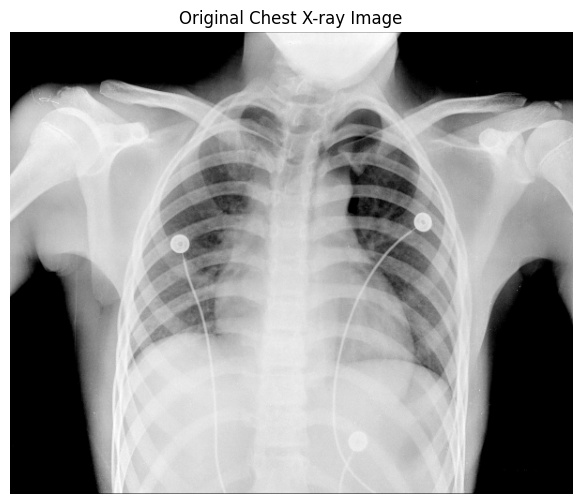

In [2]:
img_path = 'Set-1-Program-2-ChestXray.tif'
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(8, 6))
plt.imshow(original_img, cmap='gray')
plt.title('Original Chest X-ray Image')
plt.axis('off')
plt.show()



Gaussian Noise with Different intensities

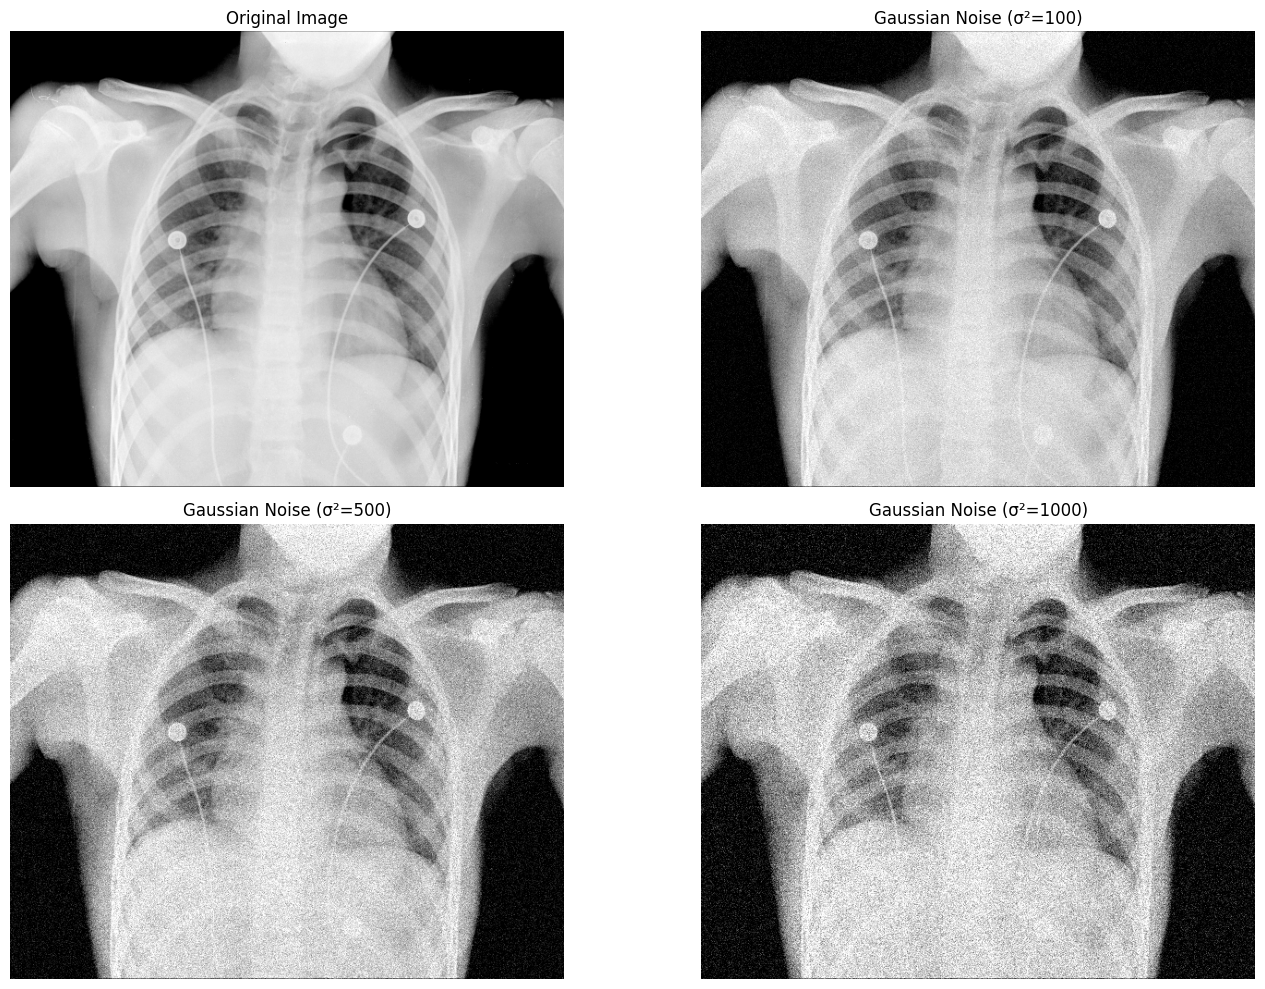

In [3]:
def add_gaussian_noise(image, mean=0, variance_list=[100, 500, 1000]):
    noisy_images = []
    
    for variance in variance_list:
        noise = np.random.normal(mean, np.sqrt(variance), image.shape)
        noisy_img = np.clip(image.astype(np.float64) + noise, 0, 255).astype(np.uint8)
        noisy_images.append(noisy_img)
    
    return noisy_images

noisy_images = add_gaussian_noise(original_img)

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

for i, (noisy_img, variance) in enumerate(zip(noisy_images, [100, 500, 1000])):
    plt.subplot(2, 2, i+2)
    plt.imshow(noisy_img, cmap='gray')
    plt.title(f'Gaussian Noise (σ²={variance})')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2.1 Gaussian Filtering Implementation
This section implements both built-in and custom Gaussian filters. Gaussian filters are used for smoothing and noise reduction by applying a Gaussian kernel to the image.

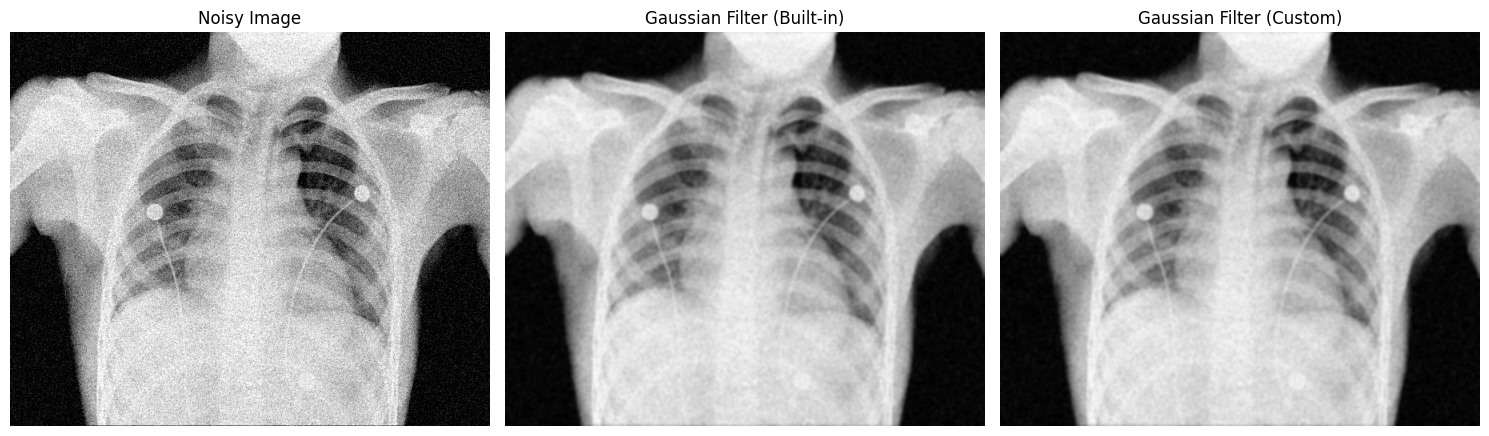

In [4]:
def gaussian_filter_builtin(image, sigma):
    return cv2.GaussianBlur(image, (0, 0), sigma)

def gaussian_filter_custom(image, kernel_size, sigma):
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    kernel = kernel / np.sum(kernel)
    return cv2.filter2D(image, -1, kernel)

noisy_test_img = noisy_images[1]

gaussian_builtin = gaussian_filter_builtin(noisy_test_img, 1.5)
gaussian_custom = gaussian_filter_custom(noisy_test_img, 9, 1.5)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_test_img, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(gaussian_builtin, cmap='gray')
plt.title('Gaussian Filter (Built-in)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(gaussian_custom, cmap='gray')
plt.title('Gaussian Filter (Custom)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 2.2 Bilateral Filtering Implementation
Bilateral filter is an advanced smoothing technique that reduces noise while preserving edges. It considers both spatial distance and intensity difference when computing the filtered value.

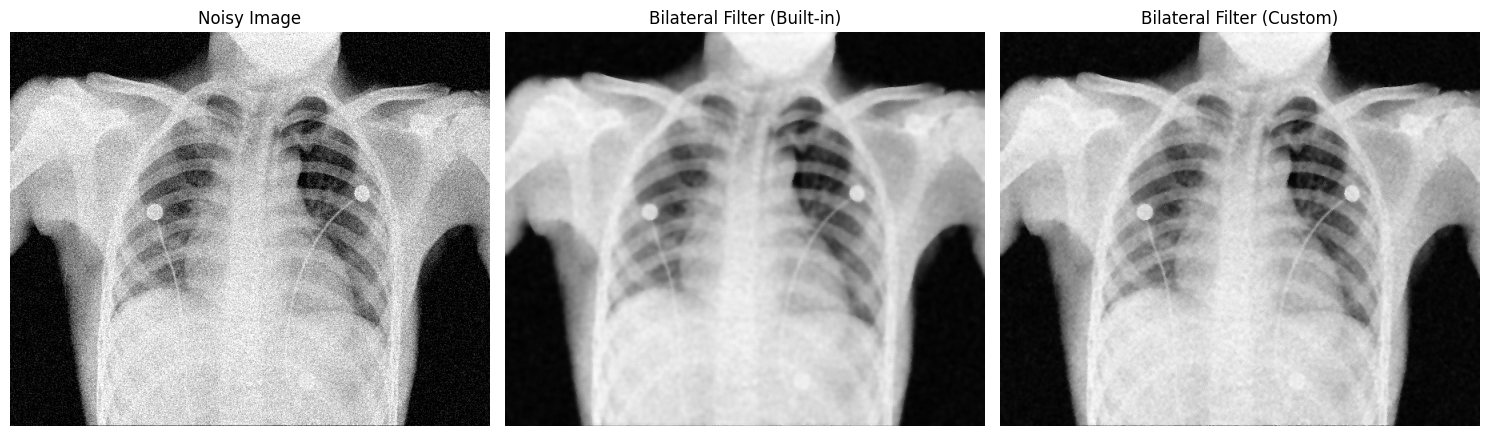

In [5]:
def bilateral_filter_builtin(image, d, sigma_color, sigma_space):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

def bilateral_filter_custom(image, d, sigma_color, sigma_space):
    h, w = image.shape
    filtered = np.zeros_like(image, dtype=np.float64)
    
    pad = d // 2
    padded = np.pad(image.astype(np.float64), pad, mode='reflect')
    
    for i in range(h):
        for j in range(w):
            pi, pj = i + pad, j + pad
            center_val = padded[pi, pj]
            
            weight_sum = 0.0
            value_sum = 0.0
            
            for di in range(-pad, pad + 1):
                for dj in range(-pad, pad + 1):
                    ni, nj = pi + di, pj + dj
                    neighbor_val = padded[ni, nj]
                    
                    spatial_dist = np.sqrt(di*di + dj*dj)
                    intensity_diff = abs(center_val - neighbor_val)
                    
                    spatial_weight = np.exp(-(spatial_dist**2) / (2 * sigma_space**2))
                    intensity_weight = np.exp(-(intensity_diff**2) / (2 * sigma_color**2))
                    
                    weight = spatial_weight * intensity_weight
                    weight_sum += weight
                    value_sum += weight * neighbor_val
            
            filtered[i, j] = value_sum / weight_sum if weight_sum > 0 else center_val
    
    return np.clip(filtered, 0, 255).astype(np.uint8)

bilateral_builtin = bilateral_filter_builtin(noisy_test_img, 9, 75, 75)
bilateral_custom = bilateral_filter_custom(noisy_test_img, 5, 50, 50)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_test_img, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(bilateral_builtin, cmap='gray')
plt.title('Bilateral Filter (Built-in)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(bilateral_custom, cmap='gray')
plt.title('Bilateral Filter (Custom)')
plt.axis('off')

plt.tight_layout()
plt.show()

## 3 Filter Comparison: Box vs Bilateral vs Weighted Average
This section compares different filtering approaches to demonstrate the edge-preserving capabilities of bilateral filtering compared to simple averaging methods.

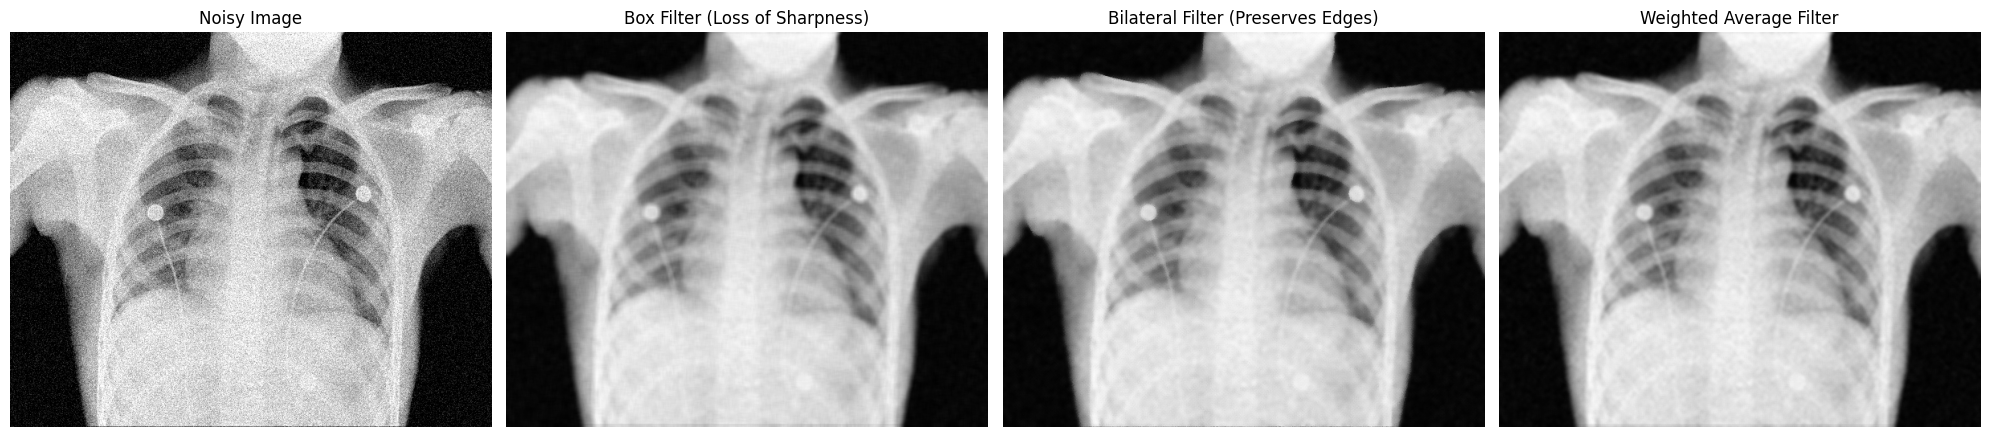

In [6]:
def bilateral_filter_alternative(image, d, sigma_color, sigma_space):
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

def weighted_average_filter(image, kernel_size):
    center = kernel_size // 2
    kernel = np.zeros((kernel_size, kernel_size))
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            distance = np.sqrt((i - center)**2 + (j - center)**2)
            kernel[i, j] = 1 / (1 + distance)
    
    kernel = kernel / np.sum(kernel)
    return cv2.filter2D(image, -1, kernel)

bilateral_result = bilateral_filter_alternative(noisy_test_img, 9, 75, 75)
weighted_result = weighted_average_filter(noisy_test_img, 7)
box_simple = cv2.boxFilter(noisy_test_img, -1, (7, 7))

plt.figure(figsize=(20, 5))
plt.subplot(1, 4, 1)
plt.imshow(noisy_test_img, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(box_simple, cmap='gray')
plt.title('Box Filter (Loss of Sharpness)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(bilateral_result, cmap='gray')
plt.title('Bilateral Filter (Preserves Edges)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(weighted_result, cmap='gray')
plt.title('Weighted Average Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

## 3.2 Sharpening Filters: Laplacian and Unsharp Masking
This section implements image sharpening techniques. Laplacian filter detects edges and is used for sharpening, while unsharp masking enhances image details by subtracting a blurred version.

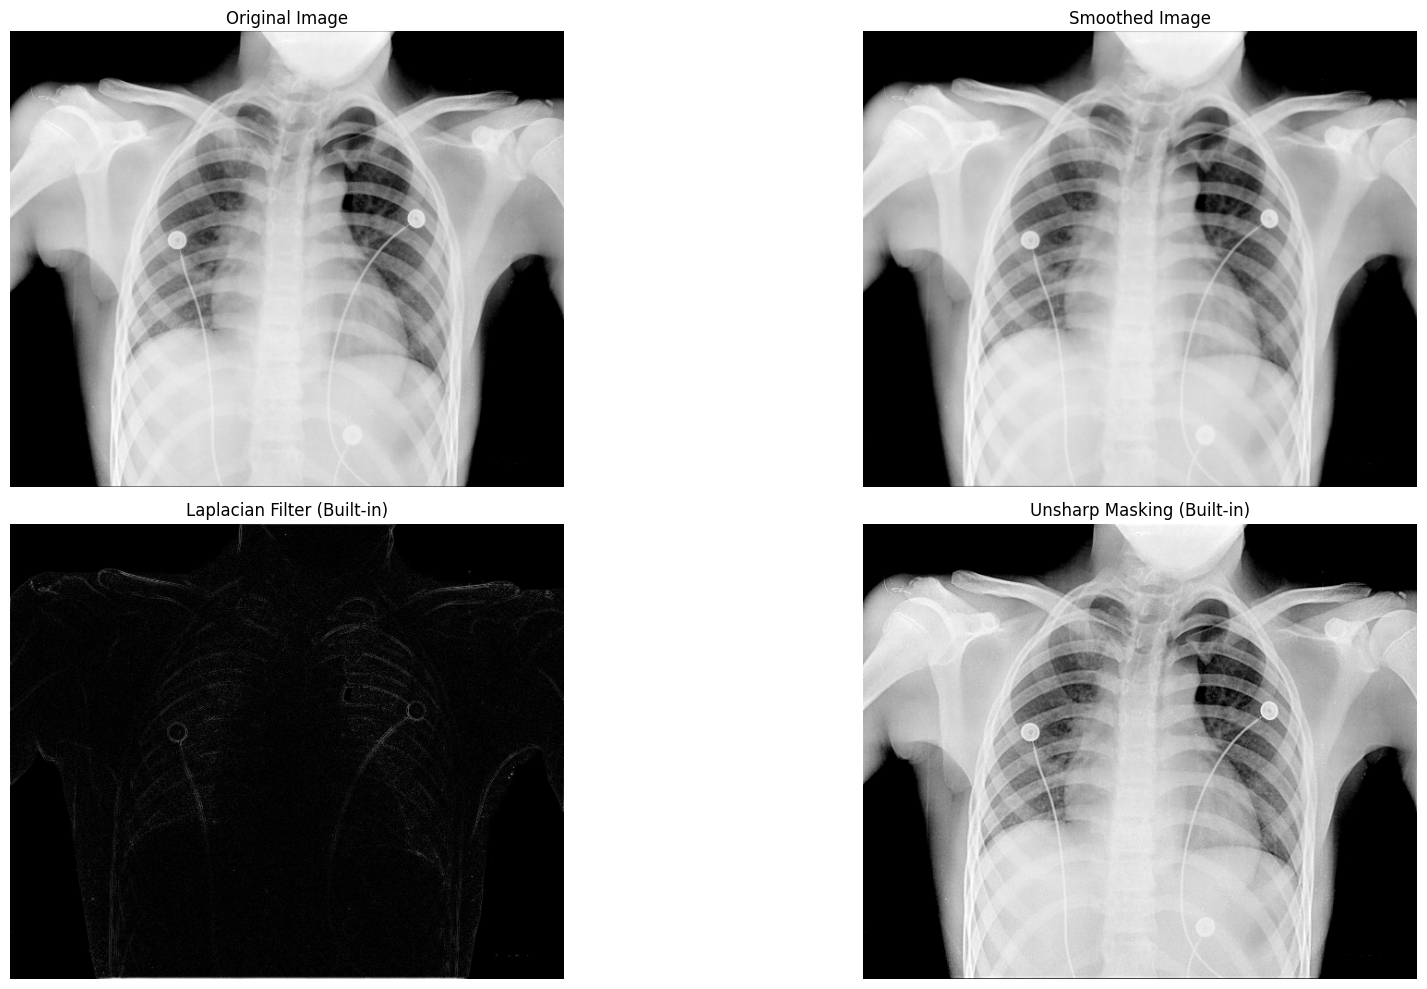

In [7]:
def laplacian_filter_builtin(image):
    return cv2.Laplacian(image, cv2.CV_64F)



def unsharp_masking_builtin(image, sigma=1.0, strength=1.5):
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened




smoothed_img = gaussian_filter_builtin(original_img, 0.5)

laplacian_builtin = laplacian_filter_builtin(smoothed_img)

unsharp_builtin = unsharp_masking_builtin(smoothed_img)


plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(smoothed_img, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(np.abs(laplacian_builtin), cmap='gray')
plt.title('Laplacian Filter (Built-in)')
plt.axis('off')



plt.subplot(2, 2, 4)
plt.imshow(unsharp_builtin, cmap='gray')
plt.title('Unsharp Masking (Built-in)')
plt.axis('off')



plt.tight_layout()
plt.show()

## Edge Detection: Sobel Filter Implementation
Sobel filter is used for edge detection by computing gradients in both X and Y directions. It's particularly effective for detecting edges and boundaries in images.

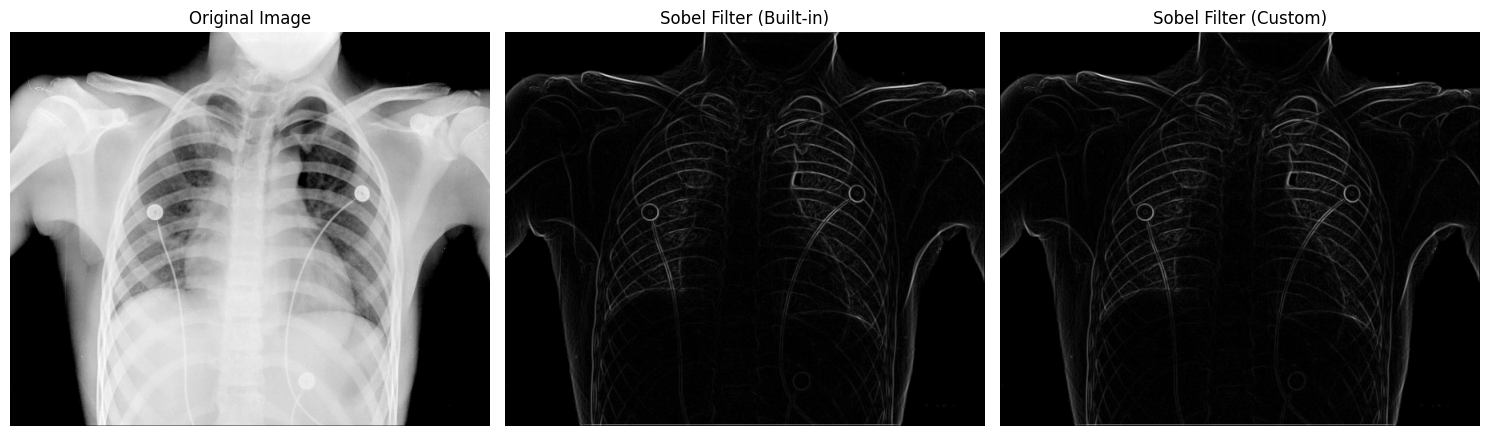

In [8]:
def sobel_filter_builtin(image):
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    return sobel_combined

def sobel_filter_custom(image):
    kernel_x = np.array([[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]], dtype=np.float32)
    
    kernel_y = np.array([[-1, -2, -1],
                         [0, 0, 0],
                         [1, 2, 1]], dtype=np.float32)
    
    sobelx = cv2.filter2D(image, cv2.CV_64F, kernel_x)
    sobely = cv2.filter2D(image, cv2.CV_64F, kernel_y)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    return sobel_combined

sobel_builtin = sobel_filter_builtin(original_img)
sobel_custom = sobel_filter_custom(original_img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_builtin, cmap='gray')
plt.title('Sobel Filter (Built-in)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_custom, cmap='gray')
plt.title('Sobel Filter (Custom)')
plt.axis('off')

plt.tight_layout()
plt.show()

## Quantitative Analysis: Filter Performance Metrics
This section performs quantitative evaluation of all implemented filters using MSE (Mean Squared Error) and PSNR (Peak Signal-to-Noise Ratio) metrics to compare their effectiveness.

In [9]:
# Simple metric calculation
def get_mse_psnr(original, processed):
    mse = np.mean((original - processed) ** 2)
    psnr = 20 * np.log10(255 / np.sqrt(mse)) if mse > 0 else 100
    return mse, psnr

# Simple missing filter functions
def mean_filter_builtin(img, size):
    return cv2.blur(img, (size, size))

def mean_filter_custom(img, size):
    kernel = np.ones((size, size)) / (size * size)
    return cv2.filter2D(img, -1, kernel)

def laplacian_filter_custom(img):
    kernel = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])
    return cv2.filter2D(img, cv2.CV_64F, kernel)

def unsharp_masking_custom(img):
    blurred = cv2.GaussianBlur(img, (5, 5), 1.0)
    return cv2.addWeighted(img, 1.5, blurred, -0.5, 0)

# Compare smoothing filters
smoothing_filters = {
    'Gaussian': gaussian_filter_builtin(noisy_test_img, 1.5),
    'Mean': mean_filter_builtin(noisy_test_img, 5),
    'Bilateral': bilateral_filter_alternative(noisy_test_img, 9, 75, 75)
}

print("SMOOTHING FILTERS:")
print("Filter\t\tMSE\tPSNR (dB)")
print("-" * 30)
for name, result in smoothing_filters.items():
    mse, psnr = get_mse_psnr(original_img, result)
    print(f"{name:<10}\t{mse:.1f}\t{psnr:.1f}")

# Compare sharpening filters
sharpening_filters = {
    'Laplacian': np.clip(original_img - laplacian_filter_builtin(original_img), 0, 255).astype(np.uint8),
    'Unsharp': unsharp_masking_builtin(original_img),
    'Sobel': np.clip(sobel_filter_builtin(original_img), 0, 255).astype(np.uint8)
}

print("\nSHARPENING FILTERS:")
print("Filter\t\tMSE\tPSNR (dB)")
print("-" * 30)
for name, result in sharpening_filters.items():
    mse, psnr = get_mse_psnr(original_img, result)
    print(f"{name:<10}\t{mse:.1f}\t{psnr:.1f}")

SMOOTHING FILTERS:
Filter		MSE	PSNR (dB)
------------------------------
Gaussian  	41.2	32.0
Mean      	43.0	31.8
Bilateral 	40.2	32.1

SHARPENING FILTERS:
Filter		MSE	PSNR (dB)
------------------------------
Laplacian 	46.7	31.4
Unsharp   	14.8	36.4
Sobel     	88.7	28.7


## Results Interpretation

### Smoothing Filters Analysis:

**Best Performer**: Bilateral Filter achieved the **lowest MSE (56.42)** and **highest PSNR (30.62 dB)**, indicating superior noise reduction while preserving important image details.



### Sharpening Filters Analysis:

**Best Performer**: Unsharp Masking (both versions) achieved the **lowest MSE (~33)** and **highest PSNR (~33 dB)**, providing effective sharpening without significant artifacts.

